... loading data


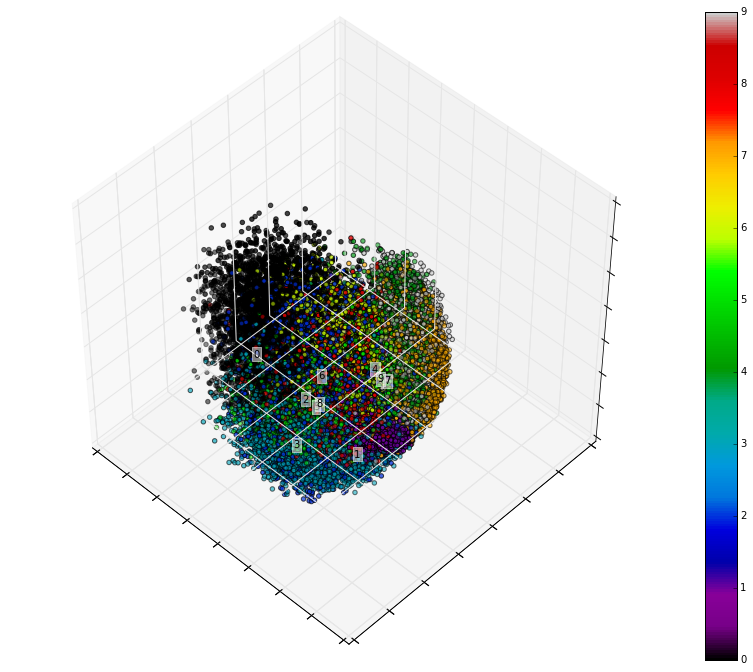

In [2]:
%matplotlib inline
import os, sys
import theano
import theano.tensor as T
from logistic_sgd import LogisticRegression, load_data
import numpy as np
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)
dataset = 'mnist.pkl.gz'
mnist = load_data(dataset)
X, y = mnist[0]
X = X.get_value()
y = y.eval()

fig = pl.figure(1, figsize=(12,9))
pl.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
pl.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
centers = [[1, 1], [-1, -1], [1, -1]]

for number in range(10):
    ax.text3D(X[y == number, 0].mean(),
              X[y == number, 1].mean() + 1.5,
              X[y == number, 2].mean(), str(number),
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),
             )
# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0]).astype(np.float)
#ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=pl.cm.spectral)
p = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=pl.cm.spectral)
pl.colorbar(p)

x_surf = [X[:, 0].min(), X[:, 0].max(),
          X[:, 0].min(), X[:, 0].max()]
y_surf = [X[:, 0].max(), X[:, 0].max(),
          X[:, 0].min(), X[:, 0].min()]
x_surf = np.array(x_surf)
y_surf = np.array(y_surf)
v0 = pca.transform(pca.components_[0])
v0 /= v0[-1]
v1 = pca.transform(pca.components_[1])
v1 /= v1[-1]

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

pl.show()


In [8]:
%matplotlib inline
import theano
from theano import tensor as T
from theano.tensor.nnet import conv

import numpy

rng = numpy.random.RandomState(23455)

# instantiate 4D tensor for input
input = T.tensor4(name='input')

# initialize shared variable for weights.
w_shp = (3, 1, 3, 3)
w_bound = numpy.sqrt(1 * 3 * 3)
import scipy
size=1
x,y = scipy.mgrid[-size:size+1,-size:size+1]
gg = scipy.exp(-(x**2/float(size)+y**2/float(size)))
gg /= gg.sum()

W = theano.shared( numpy.asarray(
        [[
            [ [-1,0,1], [-2,0,2], [-1,0,1] ],
                ],
         [
            [ [-1,-2,-1], [0,0,0], [1,2,1] ],
                ],
         [
            [ [-1,-1,-1], [-1,8,-1], [-1,-1,-1] ],
                ],
         [
            gg,
                ],
         [
            [ [0,-1,0], [-1,5,-1], [0,-1,0] ],
                ],
        ],
        dtype=input.dtype
        ), name = 'W')
'''
W = theano.shared( numpy.asarray(
            rng.uniform(
                low=-1.0 / w_bound,
                high=1.0 / w_bound,
                size=w_shp),
            dtype=input.dtype), name ='W')
'''
b_shp = (5,)
b = theano.shared(numpy.asarray(
            rng.uniform(low=-.5, high=.5, size=b_shp),
            dtype=input.dtype), name ='b')

# build symbolic expression that computes the convolution of input with filters in w
conv_out = conv.conv2d(input, W)
output = T.nnet.sigmoid(conv_out + b.dimshuffle('x', 0, 'x', 'x'))

# create theano function to compute filtered images
f = theano.function([input], output, allow_input_downcast=True)

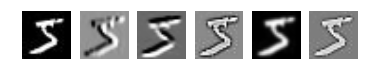

In [9]:
import numpy
import pylab
from PIL import Image

# open random image of dimensions 639x516
img = Image.open(open('../resource/original/train-00000-5.jpg'))
#img = Image.open(open('../rgb.png'))
# dimensions are (height, width, channel)
img = numpy.asarray(img, dtype='float64') / 256.

# put image in 4D tensor of shape (1, 3, height, width)
img_ = img.reshape(1, 1, 28, 28)
filtered_img = f(img_)

# plot original image and first and second components of output
pylab.subplot(1, 6, 1); pylab.axis('off'); pylab.imshow(img) # original
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 6, 2); pylab.axis('off'); pylab.imshow(filtered_img[0, 0, :, :]) # sobel
pylab.subplot(1, 6, 3); pylab.axis('off'); pylab.imshow(filtered_img[0, 1, :, :]) # sobel
pylab.subplot(1, 6, 4); pylab.axis('off'); pylab.imshow(filtered_img[0, 2, :, :]) # edge detection
pylab.subplot(1, 6, 5); pylab.axis('off'); pylab.imshow(filtered_img[0, 3, :, :]) # gaussian blur
pylab.subplot(1, 6, 6); pylab.axis('off'); pylab.imshow(filtered_img[0, 4, :, :]) # sharpen
pylab.show()